# American Census

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

## Global config

In [32]:
# Data config
path_to_csv = "adult.csv"


## Load data

In [33]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

X_test = pd.read_csv("X_test.csv")


## Helpers

In [34]:
# TODO

number_of_data_points = X_train.shape[0]
number_of_features = X_train.shape[1]


print("number of examples: ", number_of_data_points)
print("number of features: ", number_of_features)

data = np.genfromtxt('X_train.csv', delimiter=',', names=True)



X_train_data = X_train.to_dict(orient = 'list')


np.array(X_train.iloc[0,3:])


number of examples:  16280
number of features:  11


array([' Private', ' HS-grad', ' Married-civ-spouse', ' Sales',
       ' Own-child', ' Asian-Pac-Islander', ' Female', ' United-States'],
      dtype=object)

## Data exploration

### Question 1

Explore the features and target variables of the dataset. What is the right performance metric to use for this dataset?

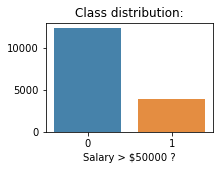

In [35]:

import seaborn as sns

plt.figure(figsize=(3,2))

feature_count = y_train['salary'].value_counts()
sns.barplot(feature_count.index, feature_count.values, alpha=0.9)
plt.title('Class distribution:')
plt.ylabel('', fontsize=12)
plt.xlabel('Salary > $50000 ?')
plt.show()


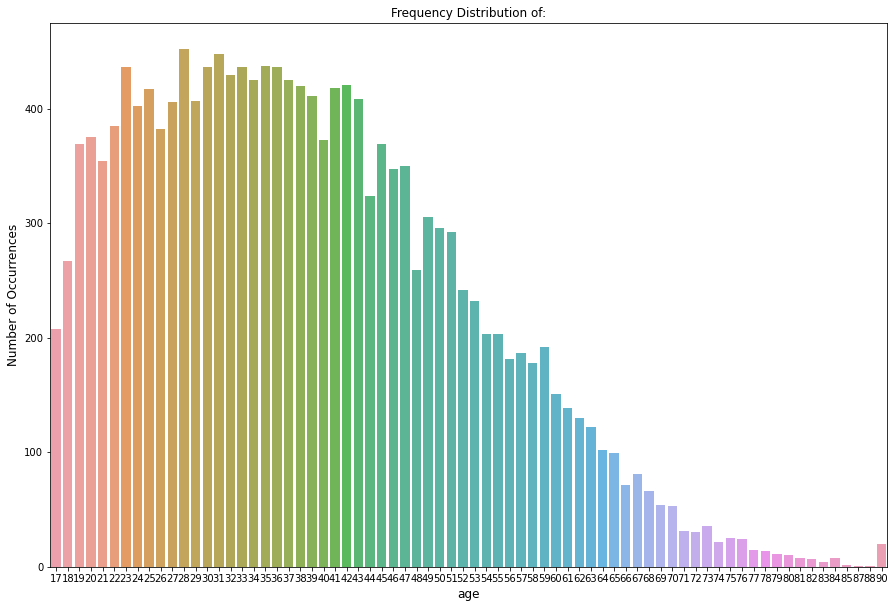

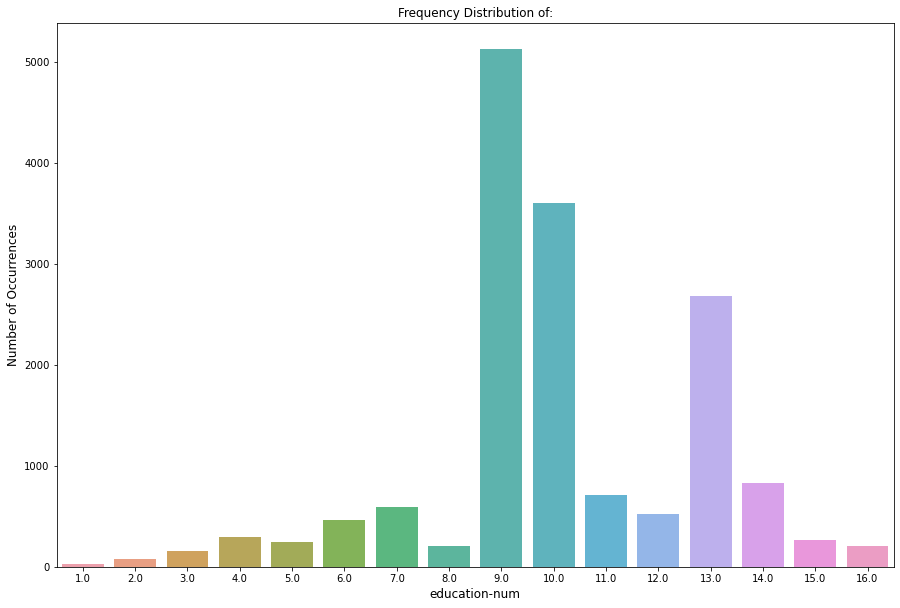

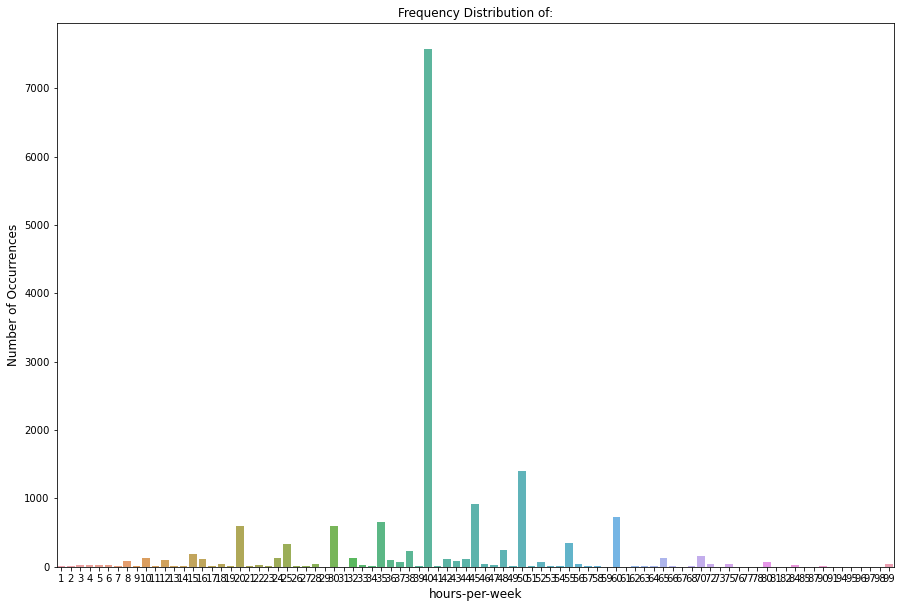

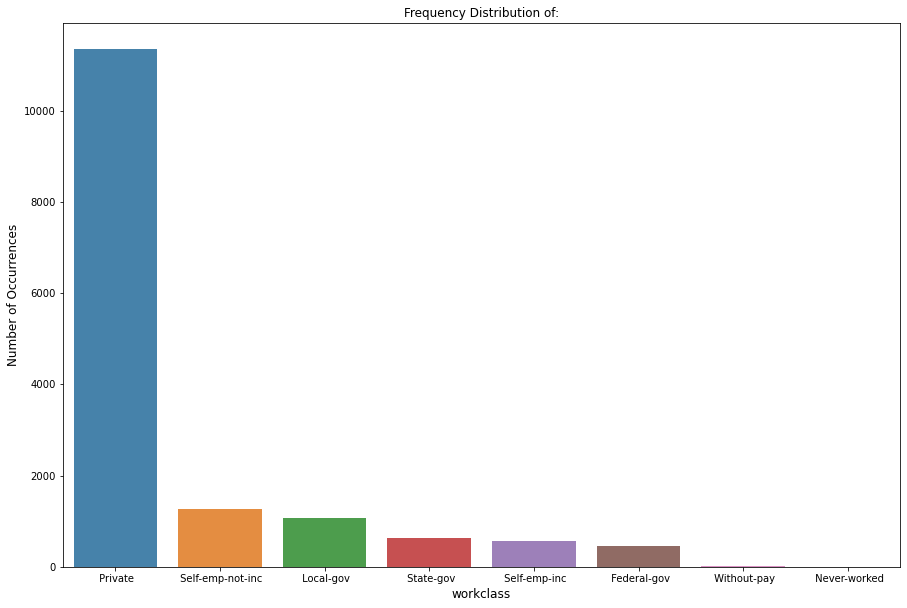

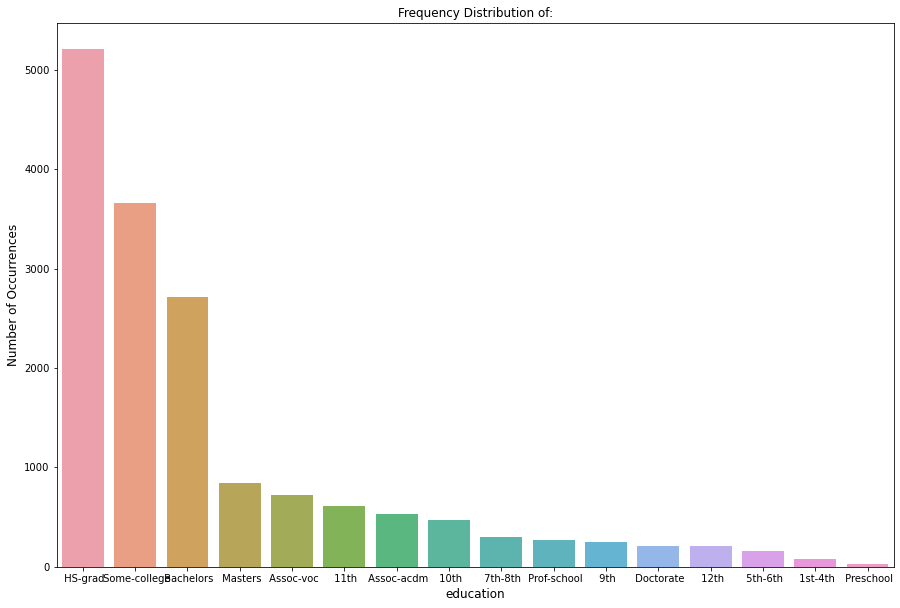

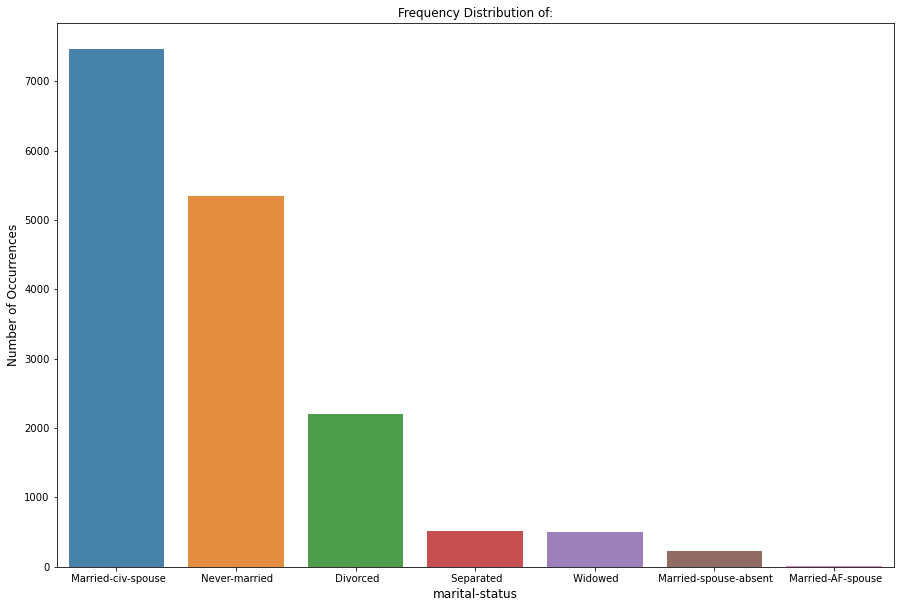

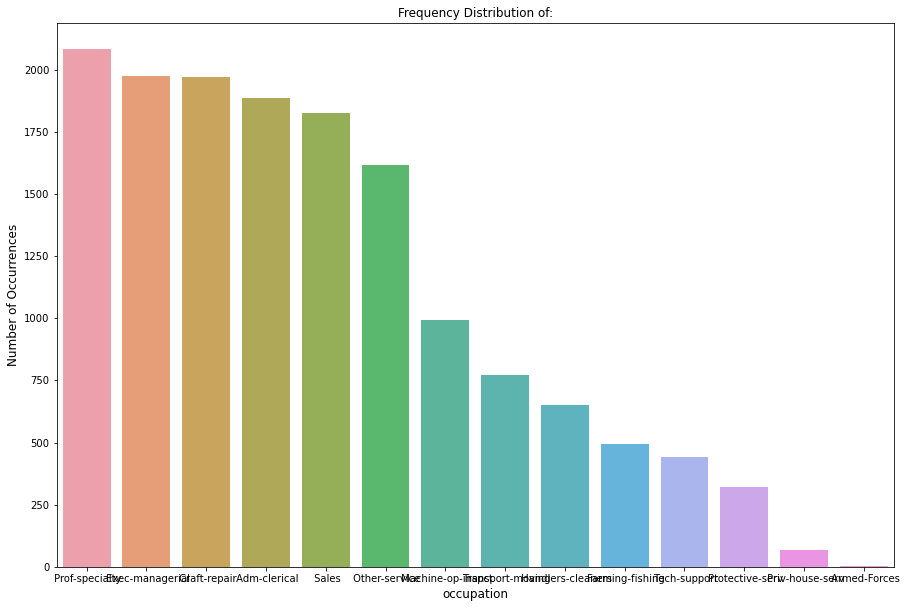

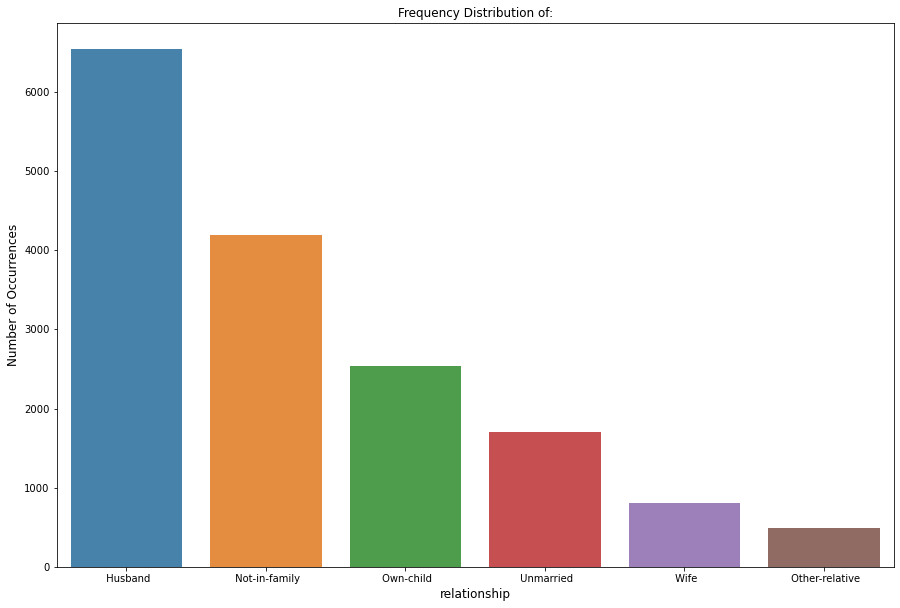

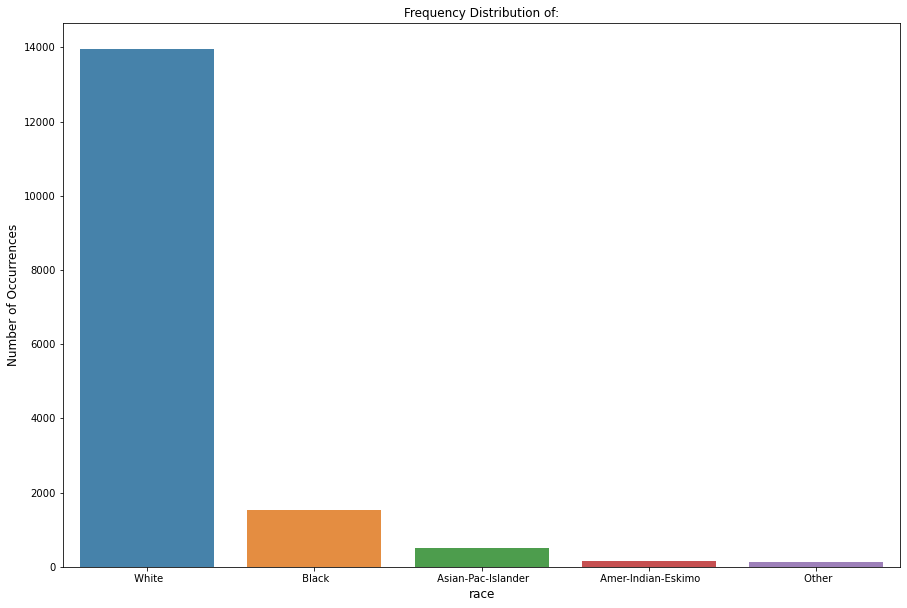

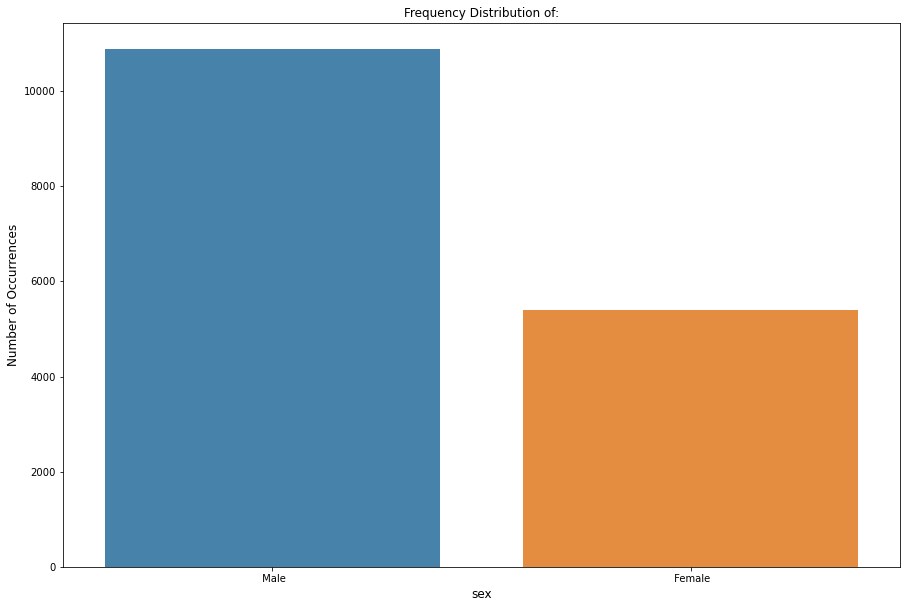

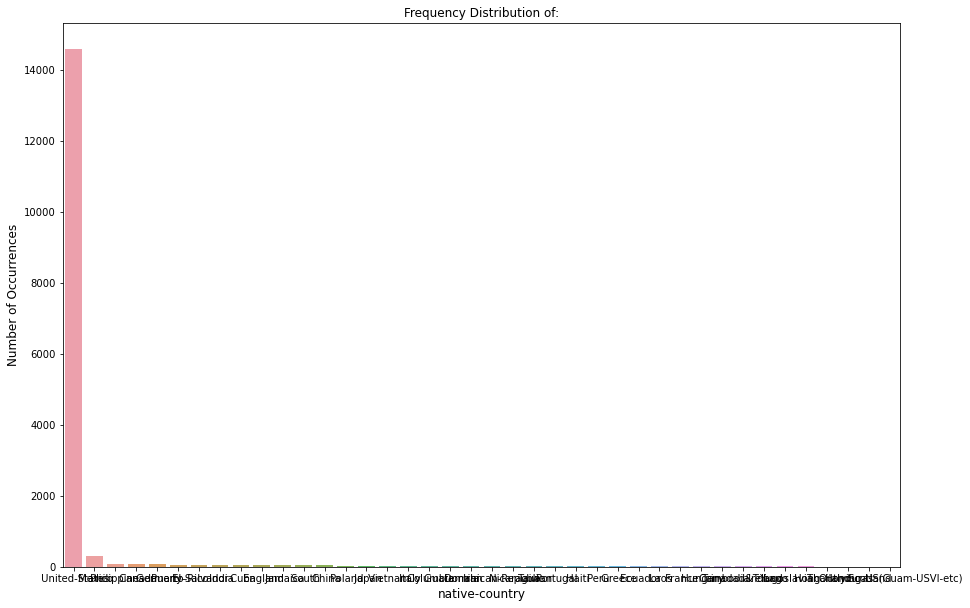

In [36]:
for feature in X_train: 
    plt.figure(figsize=(15,10))

    feature_count = X_train[feature].value_counts()
    #sns.set(style="darkgrid")
    sns.barplot(feature_count.index, feature_count.values, alpha=0.9)
    plt.title('Frequency Distribution of:')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(feature , fontsize=12)
    plt.show()
    


In [37]:
# see which features have how many NaN values? 
print(X_train.isnull().sum())

# find most common values per feature (and in case of numeric feature, maybe use the mean?)
most_common1 = X_train['education-num'].value_counts().idxmax()
most_common2 = X_train['workclass'].value_counts().idxmax()
most_common3 = X_train['occupation'].value_counts().idxmax()
most_common4 = X_train['native-country'].value_counts().idxmax()

#replace the most NaNs with most common values
X_train['education-num'].fillna(most_common1, inplace = True)
X_train['workclass'].fillna(most_common2, inplace = True) 
X_train['occupation'].fillna(most_common3, inplace = True) 
X_train['native-country'].fillna(most_common4, inplace = True) 


print(X_train.isnull().sum())

X_train_obj_df = X_train.select_dtypes(include=['object']).copy()
X_train_numeric_df = X_train.select_dtypes(['int64', 'float64'])

print(X_train_numeric_df.head())
print(X_train_obj_df.head())

age                  0
education-num      240
hours-per-week       0
workclass          936
education            0
marital-status       0
occupation        1181
relationship         0
race                 0
sex                  0
native-country     300
dtype: int64
age               0
education-num     0
hours-per-week    0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
dtype: int64
   age  education-num  hours-per-week
0   30            9.0              40
1   77           10.0               6
2   44           12.0              50
3   53           10.0              50
4   41           10.0              40
      workclass      education       marital-status         occupation  \
0       Private        HS-grad   Married-civ-spouse              Sales   
1       Private   Some-college   Married-civ-spouse     Prof-specialty   
2       Private     Assoc-acdm        Never-married

In [38]:
# First, encode the categorial features into integers. We can see that the last 8 features are categorial.

X_train_obj_df = pd.get_dummies(X_train_obj_df, columns=["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"], prefix=["work", "edu", "marital-stat", "occu", "rela", "race", "sex", "country"])
X_train_obj_df.shape

(16280, 98)

In [39]:
X_train_df = pd.concat([X_train_numeric_df, X_train_obj_df], axis = 1)

## Experiments

### Question 2
Fit the five algorithms using Scikit-learn’s default hyper-parameters. Createa useful plot that shows the performances of the algorithms.

GaussianNB
DecisionTreeClassifier
KNeighborsClassifier
SVM
LogisticRegression


,mean,std
GaussianNB,0.324925,0.034176
DecisionTreeClassifier,0.781773,0.005234
KNeighborsClassifier,0.792305,0.007275
SVM,0.810028,0.004702
LogisticRegression,0.825632,0.004013


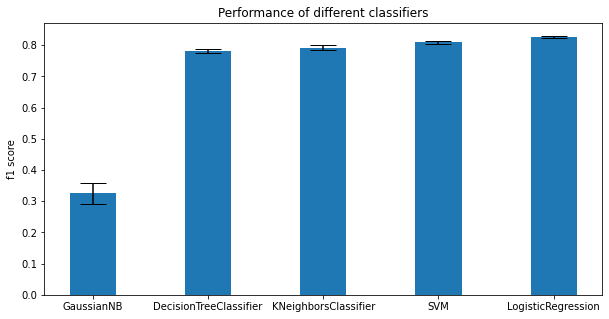

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


random_state = 42

models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=None, min_samples_leaf=2, random_state=random_state),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    "SVM": SVC(C = 10, kernel = "poly", random_state = random_state),
    "LogisticRegression": LogisticRegression(C = 10, penalty="none", random_state = random_state)
}

def k_fold_fit_and_evaluate(X, y, name, model, scoring_method, n_splits=5):
    # define pipeline to stop data leakage
    pipe = Pipeline([('scaler', StandardScaler()), (name, model)])
    
    # define evaluation procedure
    cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
    # evaluate model
    scores = cross_validate(pipe, X, y, scoring=scoring_method, cv=cv, n_jobs=-1)
    
    return scores["test_score"]


scoring_method_f1 = make_scorer(lambda true_target, prediction: f1_score(true_target, prediction, average="weighted"))

scores = {}
data = pd.DataFrame()
for name, model in models.items():
    print(name)
    metrics_f1 = k_fold_fit_and_evaluate(X_train_df, y_train, name, model, scoring_method_f1)
    scores[name] = np.mean(metrics_f1)
    mean = np.mean(metrics_f1)
    std = np.std(metrics_f1)
    
    data = pd.concat([data, pd.DataFrame(np.array([mean, std]).reshape(1, 2))], axis = 0)
    
data.columns = ['mean', 'std']
data.index = ['GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression'] 

plt.figure(figsize=(10,5))
plt.bar(['GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression'] , data['mean'], yerr = data['std'], align='center', capsize = 13, width = 0.4)
plt.title('Performance of different classifiers')
plt.ylabel('f1 score')

data.head()

### Question 3

Now perform hyper-parameter tuning on the key hyper-parameters you have previously identified.

In [11]:
from sklearn.model_selection import GridSearchCV

random_state = 42
n_splits = 5
scoring_method = make_scorer(lambda true_target, prediction: f1_score(true_target, prediction, average="weighted"))

model_parameters = {
    "GaussianNB": {
    
    },
    "DecisionTreeClassifier": {
        'DecisionTreeClassifier__random_state': [random_state],
        'DecisionTreeClassifier__max_depth': [2, 5, 7, 9, 10, None],
        'DecisionTreeClassifier__min_samples_leaf': [1, 4, 8, 12, 16, 20]
    },
    "KNeighborsClassifier": {
        'KNeighborsClassifier__n_neighbors': [3,5,7,9,11,13,15,17,19,21],
        'KNeighborsClassifier__weights': ['uniform', 'distance']
    },
    "LogisticRegression": {
        'LogisticRegression__C': [0.01, 0.1, 1, 10],
        'LogisticRegression__penalty': ['none', 'l1', 'l2', 'elasticnet'],
        'LogisticRegression__random_state': [random_state]
    },
    "SVM": {
        'SVM__C': [0.01, 0.1, 1, 10],
        'SVM__kernel': ['poly', 'linear', 'rbf', 'sigmoid'],
        'SVM__random_state': [random_state]
    }
}

for model_name, parameters in model_parameters.items():

    model = models[model_name]
    
    pipe = Pipeline([('scaler', StandardScaler()), (model_name, model)])
                
    cv = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    grid_search = GridSearchCV(pipe, parameters, cv=cv, n_jobs=-1, verbose=True, scoring=scoring_method).fit(X_train_df, y_train.values.ravel())
    
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_
    
    print(model_name)
    print("- best_score =", best_score)
    print("best paramters:")
    for k,v in best_params.items():
        print("-", k, v)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


GaussianNB
- best_score = 0.3249245852062239
best paramters:
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.6s


KeyboardInterrupt: 

### Question 4
Compare the performance of the algorithms wita and without hyper-parameter tuning.

GaussianNB
0.3249245852062239
DecisionTreeClassifier
0.8278379503099078
KNeighborsClassifier
0.8158322454438405
SVM
0.8186524305195721
LogisticRegression
0.8258563325108188


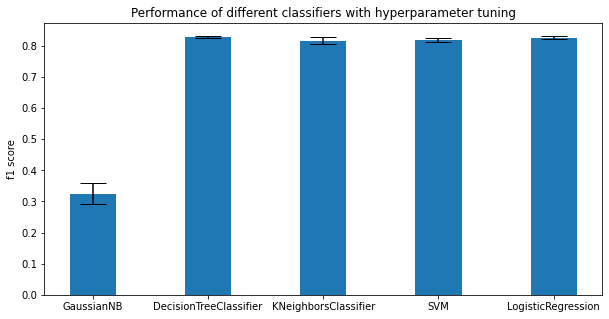

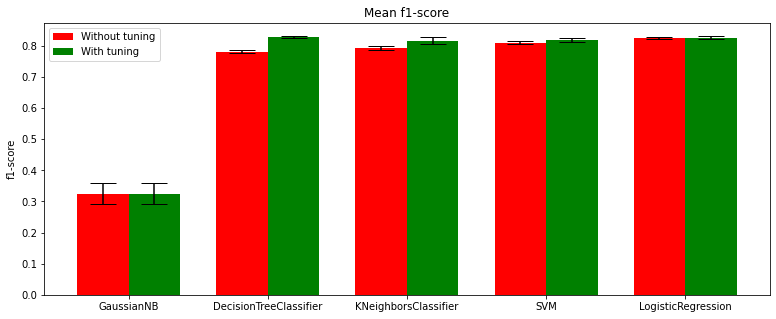

In [13]:
hyper_models = {
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(max_depth=10, min_samples_leaf=16, random_state=random_state),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=21, weights="uniform"),
    "SVM": SVC(C = 1, kernel = "linear", random_state = random_state),
    "LogisticRegression": LogisticRegression(C = 0.1, penalty="l2", random_state = random_state)
}

scoring_method_f1 = make_scorer(lambda true_target, prediction: f1_score(true_target, prediction, average="weighted"))

datah = pd.DataFrame()

fitted_tree = None

for name, model in hyper_models.items():
    print(name)
    metrics_f1 = k_fold_fit_and_evaluate(X_train_df, y_train, name, model, scoring_method_f1)

    mean = np.mean(metrics_f1)
    std = np.std(metrics_f1)
    print(mean)
    datah = pd.concat([datah, pd.DataFrame(np.array([mean, std]).reshape(1, 2))], axis = 0)
        
    
datah.columns = ['mean', 'std']
datah.index = ['GaussianNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'SVM', 'LogisticRegression']

plt.figure(figsize = (10, 5))
plt.bar(datah.index, datah['mean'], yerr = datah['std'], align = 'center', capsize = 13, width = 0.4)
plt.title('Performance of different classifiers with hyperparameter tuning')
plt.ylabel('f1 score')
N = 5
ind = np.arange(N)
width = 0.37

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)

yvals = data['mean']
rects1 = ax.bar(ind, yvals, width, color='r', align='center', yerr=data['std'], capsize=13)
zvals = datah['mean']
rects2 = ax.bar(ind+width, zvals, width, color='g', align='center', yerr=datah['std'], capsize=13)

ax.set_title('Mean f1-score')
ax.set_ylabel('f1-score')
ax.set_xticks(ind+0.5*width)
ax.set_xticklabels(datah.index)
ax.legend((rects1[0], rects2[0]), ('Without tuning', 'With tuning'))

### Question 5

 Select your best algorithm for this dataset and use it to make your predictions for the
 unknown samples.

In [40]:
# find most common values per feature (and in case of numeric feature, maybe use the mean?)
most_common1 = X_test['education-num'].value_counts().idxmax()
most_common2 = X_test['workclass'].value_counts().idxmax()
most_common3 = X_test['occupation'].value_counts().idxmax()
most_common4 = X_test['native-country'].value_counts().idxmax()

#replace the most NaNs with most common values
X_test['education-num'].fillna(most_common1, inplace = True)
X_test['workclass'].fillna(most_common2, inplace = True) 
X_test['occupation'].fillna(most_common3, inplace = True) 
X_test['native-country'].fillna(most_common4, inplace = True) 

X_test_obj_df = X_test.select_dtypes(include=['object']).copy()
X_test_numeric_df = X_test.select_dtypes(['int64', 'float64'])

X_test_obj_df = pd.get_dummies(X_test_obj_df, columns=["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", "native-country"], prefix=["work", "edu", "marital-stat", "occu", "rela", "race", "sex", "country"])

X_test_df = pd.concat([pd.DataFrame(X_test_numeric_df), X_test_obj_df], axis = 1)

scaler = preprocessing.StandardScaler().fit(X_train_df[['age', 'education-num', 'hours-per-week']])

X_train_df[['age', 'education-num', 'hours-per-week']] = scaler.transform(X_train_df[['age', 'education-num', 'hours-per-week']])
X_test_df[['age', 'education-num', 'hours-per-week']] = scaler.transform(X_test_df[['age', 'education-num', 'hours-per-week']])

model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=16, random_state=random_state)

model.fit(X_train_df, y_train)

prediction = model.predict(X_test_df)

print(np.sum(prediction))
pd.DataFrame(prediction).to_csv("GROUP_classes_problem_census.txt", index=False, header=False)

306
